![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)


# Model-Specific Interpretation with Grad-CAM for Image Data

In this Notebook, we will demonstrate how to use Grad-CAM, a gradient-based pixel attribution method, for CNNs and interpret its results.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/2025-HIDA-Spring/xai-for-cnn/2-Tutorial_Grad-CAM_for_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
from google.colab import drive
drive.mount('/content/drive')

# Switch to correct folder'
%cd /content/drive/MyDrive

In [ ]:
# Don't run this cell if you already cloned the repo 
%rm -r XAI-Tutorials
!git clone --branch 2025-HIDA-Spring https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [ ]:
# Install al required dependencies and package versions
%cd XAI-Tutorials
!pip install -r requirements_xai-for-cnn.txt
%cd xai-for-cnn

### Imports

Let's start with importing all required Python packages.

In [4]:
# Installing the necessary packages
import torch

import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

import sys  
sys.path.append('./')
import utils

sys.path.append('../models/')
from model_gradcam import GradCamModel

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [5]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

--------

## Model Loading

For this tutorial, we will use the GradCamModel class, which includes a pretrained ResNet-50 model and functions for returning the feature map activations and gradients. If you are interested, you will find this class in [*model_gradcam.py*](../models/model_gradcam.py).

Let's start loading the model:

In [6]:
# init the GradCamModel
gcmodel = GradCamModel()

# set the evaluation mode
_ = gcmodel.eval()

## Now, what does my model actually think is important in the data?

### Grad-CAM

**We prepared a small [Introduction to Grad-CAM](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/Grad-CAM.html) for you, to help you understand how this method works.**

*Note: we provide all references [here](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/Grad-CAM.html#references).*

Grad-CAM uses the feature maps produced by the last convolutional layer of a CNN. The authors of Grad-CAM argue, _“we can expect the last convolutional layers to have the best compromise between high-level semantics and detailed spatial information.”_

Grad-CAM is applied to a neural network that has finished training. The weights of the neural network are fixed. We feed an image into the network to calculate the Grad-CAM heatmap for a specific image and a chosen class of interest.

Let's use the image of an iguana and see what Grad-Cam think is important in the image for the model.

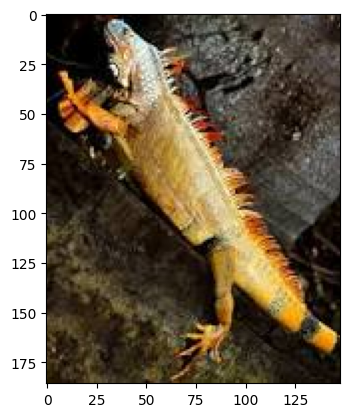

In [7]:
path_to_img = '../data/images/Iguana.jpeg'
img = utils.read_image_PIL(path_to_img)
plt.imshow(img)

Before we can apply Grad-Cam, we have to apply some transformations to ensure the input data has the correct format and is optimized for model training and inference. If you want to know more about these transformations, you can have a look at [*1-Tutorial_CNN_Model.ipynb*](./1-Tutorial_CNN_Model.ipynb) Notebook and the [*utils.py*](./utils.py) file.

In [8]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# next transform the so it is ready to be given to the model
trans_img = utils.transform_img(img, mean, std)
print('Transformed image size: ', trans_img.size())

Transformed image size:  torch.Size([1, 3, 224, 224])


**Step 1: Forward Pass**

Now we make a forward pass through the network. The model processes the input image of the iguana, returning two outputs: the feature maps from the last convolutional layer, and the class scores (before softmax activation). 

In [9]:
logits = gcmodel(trans_img) 
feat_maps = gcmodel.get_activations(trans_img).detach() # get the activations of the last convolutional layer

**Step 2: Select the Target Class**

Click [here](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) to identify the class name and see if the prediction is correct. 

In [10]:
pred_class = logits.argmax(dim=1)
print(f'Classification results: {pred_class.item()}')

Classification results: 39


Now that we verified that our model correctly classifies the iguana, we are going to choose class 39 as the class we want to explain.

In [11]:
c = 39

**Step 3: Compute the Gradients**

We now compute the gradient of the target class with respect to the feature maps of the selected convolutional layer.

In [12]:
logits[:,c].backward(retain_graph=True) #get the gradient of the class c wrt. the feature map
gradients = gcmodel.get_gradient() # pull the gradients out of the model

**Step 4: Compute the Grad-CAM**
 
We can now calculate the final Grad-CAM localization map for our selected class.

In [13]:
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # get global average pooling across the filters

for i in range(feat_maps.size(1)):
    feat_maps[:, i, :, :] *= pooled_gradients[i] # weight the filters by corresponding gradients
    
localization_map = torch.sum(feat_maps, dim=1).squeeze() # average the channels of the activations
localization_map = localization_map.numpy() # convert the map to be a numpy array
localization_map = np.maximum(localization_map, 0) # relu on top of the localization map

**Step 5: Post-processing**

Finally, we have to process the Grad-CAM results for visualisation.

In [14]:
localization_map /= np.max(localization_map) # normalize the localization_map
heatmap = cv.resize(localization_map, (img.size[0], img.size[1])) # resize to image size
heatmap = np.uint8(255 * heatmap) # normalize to [0, 255] range and convert to unsigned int

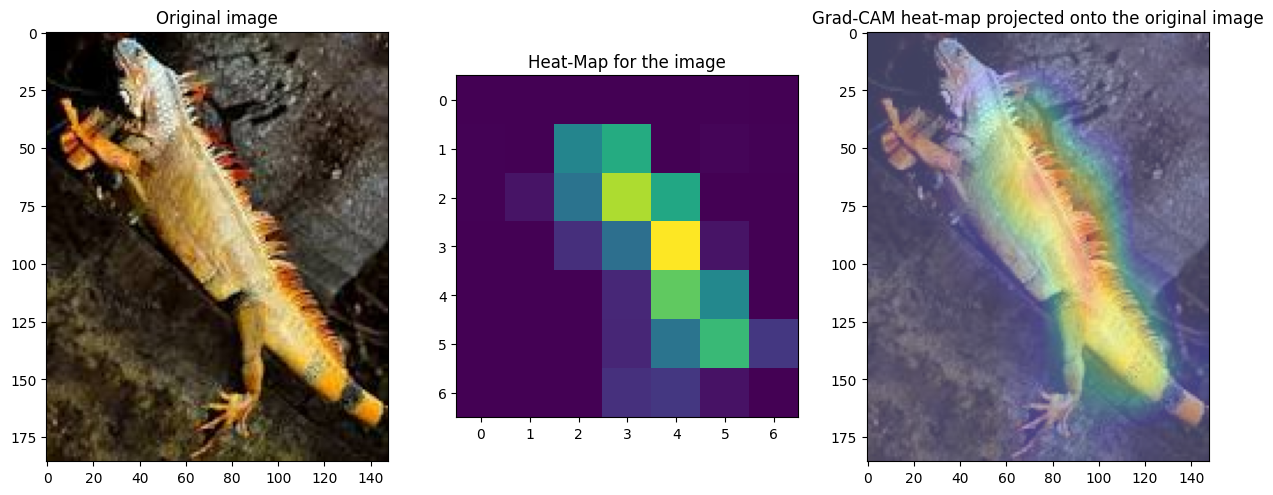

In [15]:
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title('Original image')
plt.imshow(img)

plt.subplot(132)
plt.title('Heat-Map for the image')
plt.imshow(localization_map.squeeze())

plt.subplot(133)
plt.title('Grad-CAM heat-map projected onto the original image')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.imshow(img, alpha=0.5)
plt.show()

Now let's inspect the Grad-CAM results for another image of a cat and a dog. 

*Note: we have added two functions for the localization map calculation and conversion to heatmap to [utils.py](./utils.py), which we will call below.*

In [16]:
# load image
path_to_img = '../data/images/cat_and_dog.jpg'
img = utils.read_image_PIL(path_to_img)

# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# next transform the so it is ready to be given to the model
trans_img = utils.transform_img(img, mean, std)

What is the model predicting? 

Let's look at the top two predictions and try and understand each! Take a moment to identify the class names from the [ImageNet class list](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/).

In [17]:
pred_sort = torch.argsort(gcmodel(trans_img), descending=True)
print('Top ten probabilities: ', pred_sort[0,:10])

Top ten probabilities:  tensor([281, 285, 282, 264, 263, 193, 273, 287, 231, 852])


Now let's use GradCAM to try and understand where the model is focusing for specific probabilities

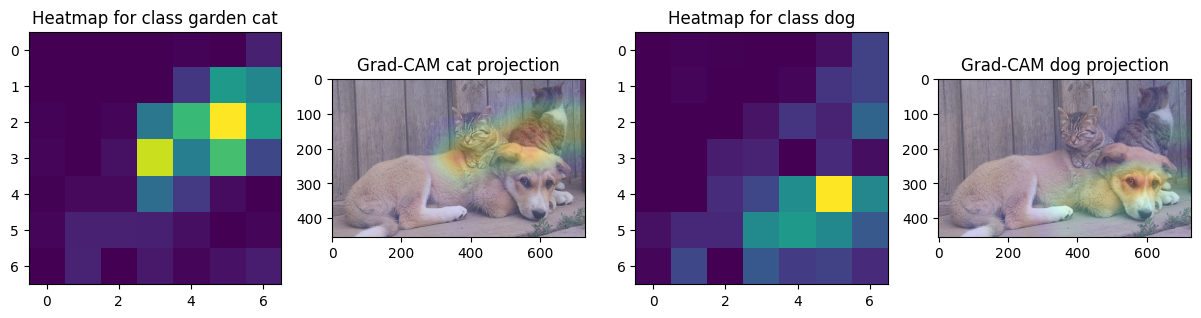

In [18]:
localization_map_cat = utils.calculate_localization_map(gcmodel, trans_img, c=282, dim=[0, 2, 3])
localization_map_dog = utils.calculate_localization_map(gcmodel, trans_img, c=231, dim=[0, 2, 3])

heatmap_cat = utils.convert_localization_map_to_heatmap(localization_map_cat, (img.size[0], img.size[1]))
heatmap_dog = utils.convert_localization_map_to_heatmap(localization_map_dog, (img.size[0], img.size[1]))

plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.title('Heatmap for class garden cat')
plt.imshow(localization_map_cat.squeeze())

plt.subplot(142)
plt.title('Grad-CAM cat projection')
plt.imshow(heatmap_cat, cmap='jet', alpha=0.4)
plt.imshow(img, alpha=0.6)

plt.subplot(143)
plt.title('Heatmap for class dog')
plt.imshow(localization_map_dog.squeeze())

plt.subplot(144)
plt.title('Grad-CAM dog projection')
plt.imshow(heatmap_dog, cmap='jet', alpha=0.4)
plt.imshow(img, alpha=0.6)
plt.show()

<font color='green'>

#### Questionnaire: What did we learn today?

1. A feature map...

   A) is the input of a neural network  
   B) is the result of a convolution  
   C) has the same disemnions of the image  
   D) doesn't keep track of the spatial information  

2. A localization map...

   A) is a linear combination of feature maps  
   B) is a synonym of a feature map   
   C) has bigger dimensions than the feature map  
   D) is a synonym of a heatmap  

3. Grad-CAM is...

   A) global method  
   B) model-agnostic method  
   C) intrinsic method  
   D) local method  

4. Applying a ReLu function to the localization map allows to...

   A) normalize the data  
   B) ignore negative influences  
   C) resize the localization map  
   D) add transparency before superposing the heatmap on the image  

5. How do we find the influence of the input pixels on a specific output?

   A) by convolving the image  
   B) by applying a ReLu function to the last layer of the model  
   C) by backpropagating the output  
   D) by making a forward pass through the model and checking if its output matches  



<font color='grey'>
    
#### Your Answer: 
1) 
    A) ❌ The input of a CNN is typically the raw image or data. The feature map is produced after the convolution operation, not before.  
    B) ✅ A feature map is generated when a filter (or kernel) slides over the input and applies the convolution operation.  
    C) ❌ Due to the use of kernels, strides, and padding, feature maps are usually smaller than the input image in width and height (though the depth increases across layers).  
    D) ❌ CNNs are designed to preserve spatial relationships, and feature maps retain the spatial layout of features.  

2) 
    A) ✅ A localization map is created by taking a weighted (linear) combination of the feature maps from a CNN layer. These weights are derived from gradients indicating how important each feature map is for a specific class.   
    B) ❌ A localization map is not the same as a feature map. It is derived from them.  
    C) ❌ A localization map typically has the same or smaller spatial dimensions as the feature maps.  
    D) ❌ While it's often visualized as a heatmap, the term "localization map" refers to a computational construct, not just a visual format.

3) 
    A) ❌ Grad-CAM provides localized explanations for individual predictions, not an overall global view of the model.  
    B) ❌ Grad-CAM is not model-agnostic. It requires access to the model’s internal gradients and convolutional layers, so it works specifically with CNN-based architectures.  
    C) ❌ Grad-CAM is a post-hoc explanation method, not intrinsic. It analyzes the model after training to interpret predictions.  
    D) ✅ Grad-CAM is a local explanation method, meaning it explains individual predictions by highlighting regions in the input (e.g., an image) that most influenced the decision.

4) 
    A) ReLU does not normalize data; it only zeroes out negative values.  
    B) ✅ Applying ReLU to the localization map filters out negative values, keeping only the positive contributions, which are assumed to positively influence the class prediction in Grad-CAM.  
    C) ❌ Resizing is done separately, not by applying ReLU.  
    D) ❌ Transparency is a visualization setting, not a result of applying ReLU.

5) 
    A) ❌ Convolution helps extract features, but it doesn’t directly tell you the influence of input pixels on a specific output.  
    B) ❌ ReLU introduces non-linearity but does not compute influence or attribution.  
    C) ✅ To determine how input pixels influence a specific output, you backpropagate gradients from that output back to the input. This is the core idea behind methods like saliency maps, Grad-CAM, and other attribution techniques.  
    D) ❌ A forward pass tells you the prediction but gives no information about why the model made that decision or which inputs were influential.

<font color='green'>

#### Question 1: What do you think are the strengths and weaknesses of Grad-CAM on image classification?

<font color='grey'>

#### Your Answer: 
Pros:
- Localization: Grad-CAM effectively localizes and highlights regions in an image that contribute to model predictions, offering valuable visual insights.
- Interpretability: It provides intuitive and interpretable heatmaps, making it easier for users to understand and trust model decisions.
- Model Agnostic: Grad-CAM can be applied to various Convolutional Neural Network (CNN) architectures.
- Non-Intrusive: It doesn't require model retraining or modification, making it a non-invasive technique for model explanation.
- Implementation Simplicity: Grad-CAM is relatively straightforward to implement, making it accessible for researchers and practitioners.
- Versatile Applications: Besides image classification, Grad-CAM can be applied to tasks like object detection and segmentation.

Cons:
- Qualitative: Grad-CAM provides qualitative visualizations, but it lacks precise quantitative measures of feature importance.
- Resolution Limitation: Generated heatmaps may have lower resolution than the original image, reducing localization precision.
- Model Dependency: The quality of Grad-CAM explanations is dependent on the model's accuracy; incorrect model predictions can lead to misleading explanations.
- Primarily for CNNs: Grad-CAM is primarily designed for Convolutional Neural Networks (CNNs), limiting its application to other model types.
- Complex Structures: It may struggle to capture intricate spatial relationships in certain images, impacting localization accuracy.
- Limited Context: Grad-CAM focuses on visual explanations within a single image and may not capture broader contextual information.